### Fetch the image from the URL and save to npz file
- **Input**: data.csv (include url images)
- **Output**: list file npz (include image numpy array)

In [73]:
import requests
from PIL import Image
import numpy as np
import pandas as pd
import os

In [82]:
def url_to_numpy(url):
    # Fetch the image from the URL
    response = requests.get(url, stream=True)

    # Open the image using PIL
    image = Image.open(response.raw)

    # Convert the image to a NumPy array
    img_array = np.array(image, dtype=np.uint8)

    return img_array

In [83]:
def save_file(index_file, merged_array):
    np.savez_compressed(f"/content/drive/MyDrive/shopee/images_array_{index_file}.npz", images_array=merged_array)
    print(f"Save file {index_file} successfully!")

In [84]:
def fix_error_image(image_array):
    print("fix_error_image", image_array.shape)

    if image_array.shape == (320, 320, 4):
        return image_array[:, :, :3]
    else:
        return np.zeros((320, 320, 3), dtype=np.uint8)

In [85]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/shopee/data.csv", header=None)

item_url = df.values[:, 0]
item_image = df.values[:, 1]
item_name = df.values[:, 2]
item_price = df.values[:, 3]

In [ ]:
index_file = 1
range_split = 500
start_index_file = 0

for index, image_url in enumerate(item_image):
    # Init
    if index == 0:
        print("init image_url", image_url)
        merged_array = [url_to_numpy(image_url)]
        continue

    if index/range_split == index_file:
        print("index", index)
        print("index_file", index_file)

        # Increase index file
        print("increase index file")
        index_file += 1

        if index/range_split  < start_index_file - 1:
            continue

        # Save data before
        if index/range_split  >= start_index_file:
            save_file(index_file=index_file-1, merged_array=merged_array)

        # Reset init file
        print()
        print("reset init")
        merged_array = [url_to_numpy(image_url)]
        continue

    # Check condition start index
    if index/range_split  < start_index_file - 1:
        continue

    # Call the function to get the image as a NumPy array
    image_array = url_to_numpy(image_url)

    # Check shape
    if image_array.shape != (320, 320, 3):
        print("image_url_fail", image_url)
        image_array = fix_error_image(image_array)

    merged_array = np.concatenate((merged_array, [image_array]), axis=0)


Check file

(500, 320, 320, 3)
<class 'numpy.uint8'>


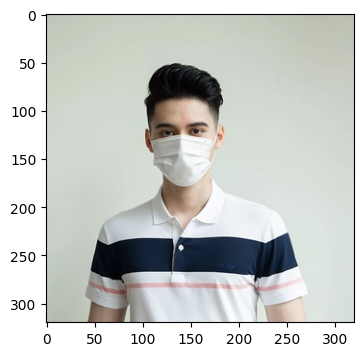

In [55]:
import numpy as np
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/shopee/"

data = np.load(file_path + "images_array_1.npz", allow_pickle=True)

imgs_feature = data["images_array"]

print(imgs_feature.shape)

print(type(imgs_feature[0][0][0][0]))

plt.figure(figsize=(4,4))
plt.imshow(imgs_feature[0])

### Load image array and inference with model
- **Input**: list file npz (include image numpy array)
- **Output**: index faiss file

In [15]:
!pip install faiss-cpu

  Using cached faiss_cpu-1.7.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)


In [1]:
import os
import numpy as np
import torch
import torchvision.models as models
import faiss

file_path = "/content/drive/MyDrive/shopee/"
list_file_array = [name for name in os.listdir(file_path) if name.endswith((".npz"))]

print(len(list_file_array))
print(list_file_array[0])

if torch.cuda.is_available():
    print("cuda")

86
images_array_3.npz
cuda


In [4]:
# Declare dimension vector output model
dimension = 1000
# Create an index with FAISS
index_faiss = faiss.IndexFlatL2(dimension)

for index_file in range(len(list_file_array)):
    file_name = f"images_array_{index_file+1}.npz"

    print("file_name:", file_name)

    # Load from npz file
    data = np.load(file_path + file_name, allow_pickle=True)

    # Get image array
    input_data = data["images_array"]

    # Convert to shape (B, C, H, W)
    input_data = input_data.transpose((0, 3, 1, 2))

    # Convert to a PyTorch tensor
    input_data = input_data.astype(np.float32) / 255.0
    input_data = torch.tensor(input_data, dtype=torch.float32)

    # Load the pre-trained model
    efficientnet_b3 = models.efficientnet_b3(weights='IMAGENET1K_V1')

    # Set the model to evaluation mode
    efficientnet_b3.eval()

    # Use a GPU (if available) for inference
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    efficientnet_b3 = efficientnet_b3.to(device)
    input_data = input_data.to(device)

    batch_size = 250
    num_samples = input_data.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size

    # Log info
    if index_file == 0:
        print("batch_size", batch_size)
        print("num_samples", num_samples)
        print("num_batches", num_batches)

    # Inference loop
    with torch.no_grad():
        for i in range(num_batches):
            # Spit to batch
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            batch = input_data[start_idx:end_idx]

            # Forward pass through the model
            outputs = efficientnet_b3(batch)

            # Convert to numpy array
            outputs = outputs.detach().cpu().numpy()

            # Add to faiss
            index_faiss.add(outputs)

# Save the index to disk
index_filename = "index.faiss"
faiss.write_index(index_faiss, file_path + index_filename)
print("total index faiss:", index_faiss.ntotal)

file_name: images_array_1.npz
batch_size 250
num_samples 500
num_batches 2
file_name: images_array_2.npz
file_name: images_array_3.npz
file_name: images_array_4.npz
file_name: images_array_5.npz
file_name: images_array_6.npz
file_name: images_array_7.npz
file_name: images_array_8.npz
file_name: images_array_9.npz
file_name: images_array_10.npz
file_name: images_array_11.npz
file_name: images_array_12.npz
file_name: images_array_13.npz
file_name: images_array_14.npz
file_name: images_array_15.npz
file_name: images_array_16.npz
file_name: images_array_17.npz
file_name: images_array_18.npz
file_name: images_array_19.npz
file_name: images_array_20.npz
file_name: images_array_21.npz
file_name: images_array_22.npz
file_name: images_array_23.npz
file_name: images_array_24.npz
file_name: images_array_25.npz
file_name: images_array_26.npz
file_name: images_array_27.npz
file_name: images_array_28.npz
file_name: images_array_29.npz
file_name: images_array_30.npz
file_name: images_array_31.npz
fil

### Test search engine

(320, 320, 3)


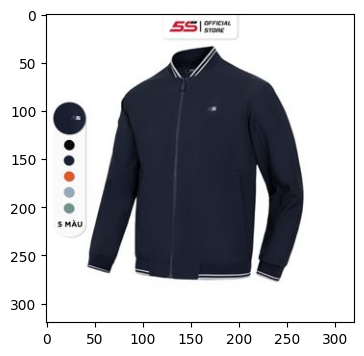

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open("test.jpg")

image_query = np.array(image, dtype=np.float32) / 255.0

print(image_query.shape)

plt.figure(figsize=(4,4))
plt.imshow(image_query)

In [6]:
import torch
import torchvision.models as models

file_path = "/content/drive/MyDrive/shopee/"

# Load the pre-trained model
efficientnet_b3 = models.efficientnet_b3(weights='IMAGENET1K_V1')

# Set the model to evaluation mode
efficientnet_b3.eval()

# Use a GPU (if available) for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_b3 = efficientnet_b3.to(device)

image_query = image_query[np.newaxis,...]
image_query = image_query.transpose((0, 3, 1, 2))
print(image_query.shape)
# Convert to a PyTorch tensor
image_query = torch.tensor(image_query, dtype=torch.float32)
image_query = image_query.to(device)


# Forward pass through the model
with torch.no_grad():
    output = efficientnet_b3(image_query)

print("output", output)
print("output", output.shape)

(1, 3, 320, 320)
output tensor([[-1.3240, -1.6573, -1.1302, -1.4438, -0.8041, -0.8724, -0.7239, -2.1771,
         -1.9853, -1.3922, -1.6080, -1.4024, -1.2192, -0.7180, -1.2234, -1.8426,
         -1.4220, -1.6896, -1.7155, -1.1861, -2.0922, -1.0612, -0.6453, -1.0337,
         -1.8540, -0.9745, -1.2673, -1.0365, -0.9624, -1.4191, -0.6630, -0.9915,
         -1.0800, -0.8555, -0.2772, -1.5045, -1.7174, -1.4901, -1.5772, -0.8105,
         -1.3091, -0.6637, -1.2079, -1.4409, -0.7021, -1.8743, -0.7861, -0.9356,
         -0.9424, -1.0759, -1.5686, -0.8854, -0.7687, -0.7876, -0.2173, -1.6188,
         -1.4245, -0.4552, -0.2521, -1.1780, -0.7912, -0.9423, -0.5914, -1.7880,
         -1.1206, -0.7107, -0.8332, -0.7179, -0.1712, -1.0450, -0.5387, -1.0140,
         -1.1125, -0.7825, -1.7293, -0.6169, -1.0472, -1.2897, -0.4773, -1.2101,
         -1.2121, -0.8694, -1.1089, -1.0369, -1.0376, -1.4024, -1.6752, -1.9573,
         -2.5288, -1.3555, -1.4043, -1.4146, -0.7950, -1.5205, -1.4411, -0.7307,
    

In [7]:
# Convert to numpy array
query_vector = output.detach().cpu().numpy()
print("query_vector", query_vector.shape)

query_vector (1, 1000)


In [8]:
# Load the index from disk
index_filename = "index.faiss"
file_path = "/content/drive/MyDrive/shopee/"
loaded_index = faiss.read_index(file_path + index_filename)

In [27]:
k = 10
distances, indices = loaded_index.search(query_vector, k)

# Results
print("\nDistances to nearest neighbors:")
print(distances[0])

print("\nNearest neighbors:")
print("indices", indices)


Distances to nearest neighbors:
[1.0760993e-09 2.3084515e+02 2.5001738e+02 2.5262924e+02 2.5771716e+02
 2.6428827e+02 2.6773419e+02 2.8045334e+02 2.8227570e+02 2.8692014e+02]

Nearest neighbors:
indices [[42999 20275 28591 20337 41745 32312 41462 28655 20989  6879]]


In [28]:
# Read the CSV file into a pandas DataFrame
import pandas as pd

df = pd.read_csv(file_path + "data.csv", header=None)

item_url = df.values[:, 0]
item_image = df.values[:, 1]
item_name = df.values[:, 2]
item_price = df.values[:, 3]

In [29]:
for index in indices[0]:
    print(index)
    print("item_name", item_name[index])
    print("item_url", item_image[index])
    print()

42999
item_name Áo Khoác Bomber Nam 5S, Cản Gió, Chống Bám Bụi, Thiết Kế Basic Trẻ Trung, Lịch Lãm (AKB22001)
item_url https://down-vn.img.susercontent.com/file/sg-11134201-22120-wuwhiuqdnykv7e_tn

20275
item_name Áo khoác dù 2 lớp sọc tay thêu logo cao cấp LADOS-2050 co giãn, thoải mái, chống nước, form đẹp
item_url https://down-vn.img.susercontent.com/file/88d59faf7610d1d10b8a3870ab607625_tn

28591
item_name Áo thun thể thao nam dài tay cổ bẻ kiểu thun co giãn thoáng mát SPMADT05 PigoFashion chọn màu
item_url https://down-vn.img.susercontent.com/file/sg-11134201-22100-g2hd7tps86iv2e_tn

20337
item_name Áo khoác nam trơn đen cao cấp LADOS 2048 vải PC cotton dày, form đẹp
item_url https://down-vn.img.susercontent.com/file/499384788594120f83702bcd2c3ec133_tn

41745
item_name Áo Khoác Cardigan Nam Nữ Đơn Giản Ngân Hà Space Y2010 Ver10 21363 |YaMe|
item_url https://down-vn.img.susercontent.com/file/vn-11134207-7qukw-lfz6tf13y4mv71_tn

32312
item_name Áo Polo Nữ Long Sleeves , Chất Vải Dệt

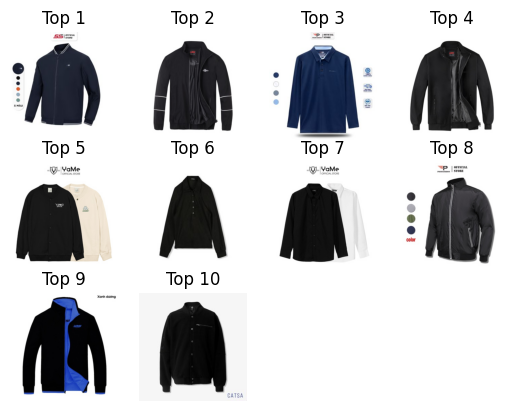

In [31]:
import requests

def url_to_numpy(url):
    # Fetch the image from the URL
    response = requests.get(url, stream=True)

    # Open the image using PIL
    image = Image.open(response.raw)

    # Convert the image to a NumPy array
    img_array = np.array(image, dtype=np.uint8)

    return img_array

for i, index in enumerate(indices[0]):
    url = item_image[index]
    img_array = url_to_numpy(url)
    plt.subplot(3, 4, i+1)
    plt.title(f"Top {i+1}")
    plt.axis('off')
    plt.imshow(img_array)
plt.show()